# California housing regression

In this notebook we'll use the ``ITEA_regressor`` to search for a good expression, that will be encapsulated inside the  ``ITExpr_regressor`` class, and it will be used for the regression task of predicting california housing prices.

In [1]:
import numpy  as np
import pandas as pd

from sklearn import datasets

from sklearn.model_selection import train_test_split
from IPython.display         import display, Math, Latex

import matplotlib.pyplot as plt

from itea.regression import ITEA_regressor
from itea.inspection import *

import warnings; warnings.filterwarnings('ignore')

The California Housing data set contains 8 features.

In this notebook, we'll provide the transformations functions and its derivatives, instead of using the itea feature of extracting the derivatives using jax.

## Creating and fitting an ``ITEA_regressor``

In [2]:
housing_data = datasets.fetch_california_housing() 
X, y         = housing_data['data'], housing_data['target']
labels       = housing_data['feature_names']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

tfuncs = {
    'log'      : np.log,
    'sqrt.abs' : lambda x: np.sqrt(np.abs(x)), 
    'id'       : lambda x: x,
    'sin'      : np.sin,
    'cos'      : np.cos,
    'exp'      : np.exp
}

tfuncs_dx = {
    'log'      : lambda x: 1/x,
    'sqrt.abs' : lambda x: x/( 2*(np.abs(x)**(3/2)) ),
    'id'       : lambda x: np.ones_like(x),
    'sin'      : np.cos,
    'cos'      : lambda x: -np.sin(x),
    'exp'      : np.exp,
}

reg = ITEA_regressor(
    gens         = 50,
    popsize      = 50,
    max_terms    = 5,
    expolim      = (-2, 2),
    verbose      = 10,
    tfuncs       = tfuncs,
    tfuncs_dx    = tfuncs_dx,
    labels       = labels,
    random_state = 42,
    simplify_method = 'simplify_by_var'
).fit(X_train, y_train)

gen 	 min_fitness 	 mean_fitness 	 max_fitness 	 remaining (s)
0 	 0.828697204387871 	 1.1163040338013304 	 1.153675314530364 	 0min56seg
10 	 0.7903571645539493 	 0.8258082130179909 	 0.9147393528349665 	 2min3seg
20 	 0.7741353544571407 	 0.7826882136239719 	 0.815990824243841 	 2min13seg
30 	 0.7751833470732888 	 0.7793975693019894 	 0.8089621701482773 	 1min37seg
40 	 0.7698501470821243 	 0.7809081037138008 	 0.8270478815796867 	 0min43seg


## Inspecting the results

We can see the convergence of the fitness, number of terms or tree complexity by using the ``ITEA_summarizer``, a inspector class focused on the ``ITEA``:

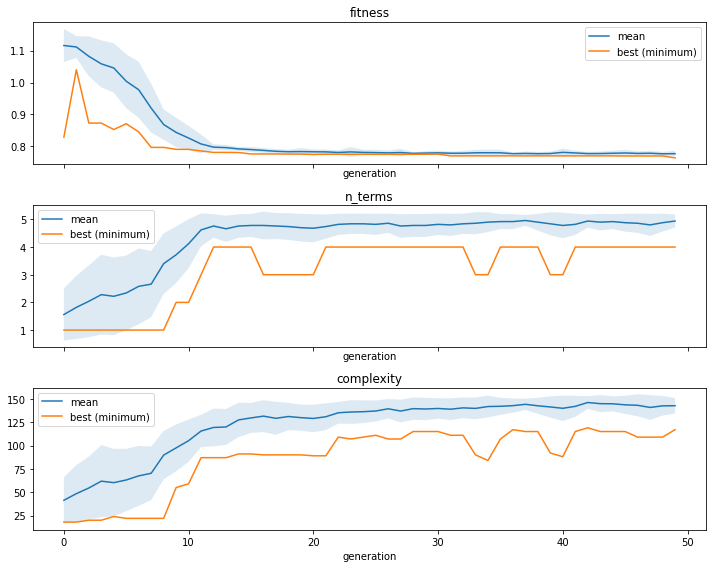

In [3]:
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

summarizer = ITEA_summarizer(itea=reg).fit(X_train, y_train)

summarizer.plot_convergence(
    data=['fitness', 'n_terms', 'complexity'],
    ax=axs,
    show=False
)

plt.tight_layout()
plt.show()

Now that we have fitted the ITEA, our ``reg`` contains the ``bestsol_`` attribute, which is an fitted instance of ``ITExpr_regressor`` ready to be used. Lets see the final expression and the execution time.

In [4]:
final_itexpr = reg.bestsol_

print('\nFinal expression:\n', final_itexpr.to_str(term_separator=' +\n'))
print(f'\nElapsed time: {reg.exectime_}')


Final expression:
 0.618*log(MedInc^-2 * HouseAge^0 * AveRooms^-2 * AveBedrms^2 * Population^0 * AveOccup^2 * Latitude^-2 * Longitude^2) +
3.283*log(MedInc^2 * HouseAge * AveRooms^-1 * AveBedrms^-1 * Population^0 * AveOccup^-1 * Latitude^-2 * Longitude^2) +
0.191*log(MedInc^-1 * HouseAge^-2 * AveRooms * AveBedrms * Population^2 * AveOccup^-1 * Latitude * Longitude^-2) +
-1.459*log(MedInc^2 * HouseAge^2 * AveRooms^-2 * AveBedrms^-2 * Population^0 * AveOccup^-1 * Latitude^-2 * Longitude^-2) +
-0.18*log(MedInc * HouseAge^-2 * AveRooms^-2 * AveBedrms^-2 * Population^2 * AveOccup^0 * Latitude^-2 * Longitude^0) +
-33.276

Elapsed time: 209.73841261863708


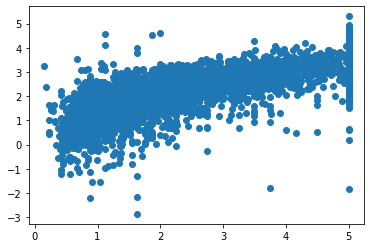

In [5]:
fig, axs = plt.subplots()

axs.scatter(y_test, final_itexpr.predict(X_test))
plt.show()

We can use the ``ITExpr_inspector`` to see informations for each term.

In [6]:
display(pd.DataFrame(
    ITExpr_inspector(
        itexpr=final_itexpr, tfuncs=tfuncs
    ).fit(X_train, y_train).terms_analysis()
))

,coef,func,strengths,coef\nstderr.,mean pairwise\ndisentanglement,mean mutual\ninformation,prediction\nvar.
0,0.618,log,"[-2, 0, -2, 2, 0, 2, -2, 2]",0.019,0.124,0.266,0.804
1,3.283,log,"[2, 1, -1, -1, 0, -1, -2, 2]",0.057,0.365,0.507,12.562
2,0.191,log,"[-1, -2, 1, 1, 2, -1, 1, -2]",0.01,0.320,0.480,0.154
3,-1.459,log,"[2, 2, -2, -2, 0, -1, -2, -2]",0.03,0.328,0.495,5.245
4,-0.18,log,"[1, -2, -2, -2, 2, 0, -2, 0]",0.008,0.180,0.405,0.165
5,-33.276,intercept,---,0.655,0.000,0.000,0.000


By using the ``ITExpr_texifier``, we can create formatted LaTeX strings of the final expression and its derivatives.

In [7]:
# The final expression
display(Latex(
    '$ ITExpr = ' + ITExpr_texifier.to_latex(
        final_itexpr,
        term_wrapper=lambda i, term: r'\underbrace{' + term + r'}_{\text{term ' + str(i) + '}}'
    ) + '$'
))

<IPython.core.display.Latex object>

In [8]:
# List containing the partial derivatives
derivatives_latex = ITExpr_texifier.derivatives_to_latex(
    final_itexpr,
    term_wrapper=lambda i, term: r'\underbrace{' + term + r'}_{\text{term ' + str(i) + r' partial derivative}}'
)

# displaying one of its derivatives
display(Latex(
    r'$ \frac{\partial}{\partial ' + labels[0] + '} ITExpr = ' + derivatives_latex[0] + '$'
))

<IPython.core.display.Latex object>

## Explaining the IT expression using Partial Effects

We can obtain feature importances using the Partial Effects and the ``ITExpr_explainer``.

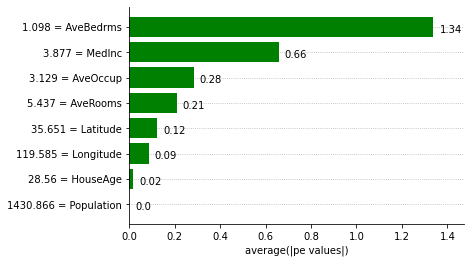

In [9]:
explainer = ITExpr_explainer(
    itexpr=final_itexpr, tfuncs=tfuncs, tfuncs_dx=tfuncs_dx).fit(X, y)

explainer.plot_feature_importances(
    X=X_train,
    importance_method='pe',
    grouping_threshold=0.0,
    barh_kw={'color':'green'}
)

The Partial Effects at the Means can help understand how the contribution of each variable changes according to its values, when their covariables are fixed at the means.

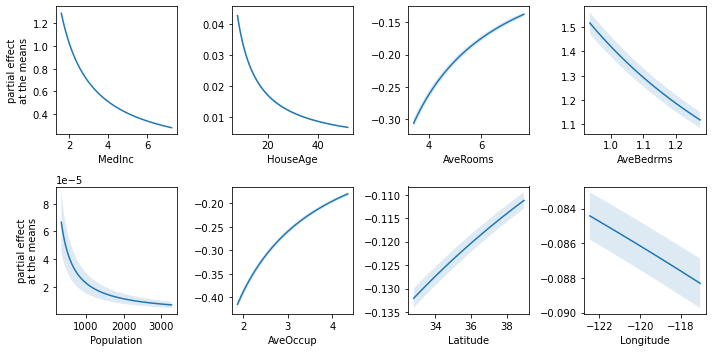

In [10]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5))

explainer.plot_partial_effects_at_means(
    X=X_test,
    features=range(8),
    ax=axs,
    num_points=100,
    share_y=False,
    show_err=True,
    show=False
)

plt.tight_layout()
plt.show()

Finally, we can also plot the mean relative importances of each feature by calculating the average Partial Effect for each interval when the output is discretized.

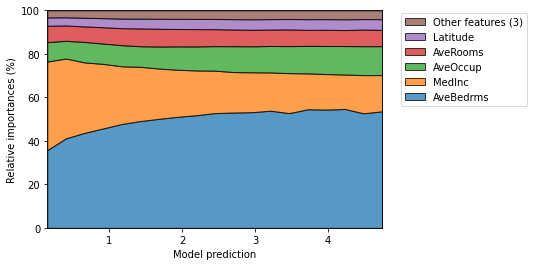

In [11]:
explainer.plot_normalized_partial_effects()